# Load data

In [1]:
# Import libraries
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FormatStrFormatter
from matplotlib.gridspec import GridSpec
#from adjustText import adjust_text
import matplotlib.pyplot as plt
from matplotlib import gridspec
#import plotly.express as px
from Functions import SB_Albanese2020, add_accents
import pandas as pd 
import numpy as np
import datetime 
#import imageio
import os
pd.set_option('display.max_colwidth', None)

In [2]:
df = pd.read_csv('../MediaSharingIndex/Data/data.csv')
df.head(n = 5)

,date,url,outlet,dynamic_opinion,tid,uid,hour,date_url,title,pos_CL,...,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9
0,2019-03-01,https://www.clarin.com/politica/cristina-hijos-juicio-lavar-dinero-hoteles_0_K1h9GP1dX.html,Clarin,NaN,3123001870860070177,-5290478328161710131,02:02:20,2019/02/28,"Cristina y sus hijos, a juicio por lavar dinero con los hoteles",0,...,0.0,0.088462,0.760143,0.029171,0.0,0.122224,0.0,0.0,0.0,0.0
1,2019-03-01,https://www.clarin.com/politica/cristina-hijos-juicio-lavar-dinero-hoteles_0_K1h9GP1dX.html,Clarin,NaN,1161354566247419187,1984147057615254567,02:02:04,2019/02/28,"Cristina y sus hijos, a juicio por lavar dinero con los hoteles",0,...,0.0,0.088462,0.760143,0.029171,0.0,0.122224,0.0,0.0,0.0,0.0
2,2019-03-01,https://www.clarin.com/politica/cristina-hijos-juicio-lavar-dinero-hoteles_0_K1h9GP1dX.html,Clarin,NaN,-8265852459726288982,907971274336289915,02:16:55,2019/02/28,"Cristina y sus hijos, a juicio por lavar dinero con los hoteles",0,...,0.0,0.088462,0.760143,0.029171,0.0,0.122224,0.0,0.0,0.0,0.0
3,2019-03-01,https://www.clarin.com/politica/cristina-hijos-juicio-lavar-dinero-hoteles_0_K1h9GP1dX.html,Clarin,NaN,2424256138563082008,-1315437987437732754,02:16:21,2019/02/28,"Cristina y sus hijos, a juicio por lavar dinero con los hoteles",0,...,0.0,0.088462,0.760143,0.029171,0.0,0.122224,0.0,0.0,0.0,0.0
4,2019-03-01,https://www.clarin.com/politica/cristina-hijos-juicio-lavar-dinero-hoteles_0_K1h9GP1dX.html,Clarin,NaN,-8244136094798448801,6507777798650809238,02:28:17,2019/02/28,"Cristina y sus hijos, a juicio por lavar dinero con los hoteles",0,...,0.0,0.088462,0.760143,0.029171,0.0,0.122224,0.0,0.0,0.0,0.0


In [3]:
# Group and count articles in the main DataFrame by 'outlet' and sort descending
dfg = df.groupby('outlet').count().sort_values(by='tid', ascending=False).reset_index()

# Define the main outlets as the first 6 that are most frequently shared:
print('dfg: \n', dfg[['outlet','tid']].rename(columns = {'tid':'# tweets'}).head(6))
main_outlets = dfg['outlet'][0:6].to_list()

dfg: 
           outlet  # tweets
0     El Destape    307021
1         Clarin    160226
2        Infobae    141902
3      La Nacion    104183
4  Todo Noticias     95286
5      Pagina 12     76274


# Calculate Sentiment Bias (SB)

## SB by news articles

Calculate the sentiment bias (SB) of the news articles

In [4]:
df['SB'] = df.apply(lambda row: SB_Albanese2020(row), axis = 1)

Dinamic model of votting: We choose the intention of votting as the label for each tweet

## Mean SB by media outlet

We drop the news duplicated

In [5]:
data = df.copy()
data.drop_duplicates('url', inplace=True)

### Calculate SB

Then we calculate the mean sentiment bias of each outlet media

In [6]:
sb_by_outlet = data.groupby('outlet')['SB'].mean().copy()
# Las ordenamos de SB positivo a negativo
sb_by_outlet.sort_values(inplace = True, ascending = False)
sb_by_outlet

outlet
Radio Mitre            0.018723
La Nacion              0.017314
Clarin                 0.013843
Todo Noticias          0.011042
Infobae               -0.005873
El Litoral            -0.007791
El Dia                -0.016239
Radio Dos             -0.024567
Perfil                -0.026037
El Cronista           -0.035990
Ambito Financiero     -0.053359
Contexto              -0.065660
Jornada               -0.070813
Minuto Uno            -0.132435
El Destape            -0.137041
La Izquierda Diario   -0.146203
Pagina 12             -0.177808
Name: SB, dtype: float64

In [7]:
# News articles with SB
data_with_sentiment = data.dropna(subset = ['SB'])

### Calculate  SB Error 

Bootstraping to Calculate SB Error by Outlet

In [8]:
# Create a list of unique outlets from the 'sb_by_outlet' DataFrame
unique_ordered_outlets = sb_by_outlet.index

# Initialize an empty list to store quantiles of SB values
quantiles99 = []

# Iterate over each outlet
for outlet in unique_ordered_outlets:
    
    # Create a copy of the DataFrame containing sentiment data for the current outlet
    data_SB_outlet = data_with_sentiment[data_with_sentiment.outlet == outlet].copy()
    
    # Initialize an empty list to store SB values from bootstrap samples
    SB_bootst = []
    
    # Perform 1000 bootstrap iterations
    for iteration in range(1000):
        
        # Randomly sample from the data with replacement
        sample = data_SB_outlet.sample(n=data_SB_outlet.shape[0], replace=True)
        
        # Calculate the mean SB value for the sample and store it in the list
        SB_bootst.append(sample['SB'].mean())
    
    # Calculate and append the 0.5th and 99.5th quantiles of the SB values
    quantiles99.append(np.quantile(SB_bootst, q=[0.005, 0.995]))


Assigning Quantiles to Calculate Sesgo (Bias) by Outlet

In [9]:
# Create a DataFrame to store the data by outlet
sb_by_outlet = pd.DataFrame(sb_by_outlet)

# Reset the index of the DataFrame data_SB_outlet
sb_by_outlet.reset_index(inplace=True)

# Assign the 0.5th quantile values to the '1%' column
sb_by_outlet['1%'] = [q[0] for q in quantiles99]

# Assign the 99.5th quantile values to the '99%' column
sb_by_outlet['99%'] = [q[1] for q in quantiles99]

# Set the 'outlet' column as the index of data_SB_outlet
sb_by_outlet.set_index('outlet', inplace=True)
print('sb_by_outlet contains mean SB values for each outlet, along with their corresponding quantiles (1% and 99%).')
sb_by_outlet

sb_by_outlet contains mean SB values for each outlet, along with their corresponding quantiles (1% and 99%).


,SB,1%,99%
outlet,,,
Radio Mitre,0.018723,-0.000987,0.039520
La Nacion,0.017314,0.004572,0.030683
Clarin,0.013843,0.002527,0.025265
Todo Noticias,0.011042,-0.007069,0.031501
Infobae,-0.005873,-0.016898,0.006410
El Litoral,-0.007791,-0.036729,0.020691
El Dia,-0.016239,-0.041398,0.010730
Radio Dos,-0.024567,-0.062071,0.014638
Perfil,-0.026037,-0.039873,-0.012122


In [10]:
sb_by_outlet.sort_values('SB', inplace = True)

# Plot mean SB by outlet

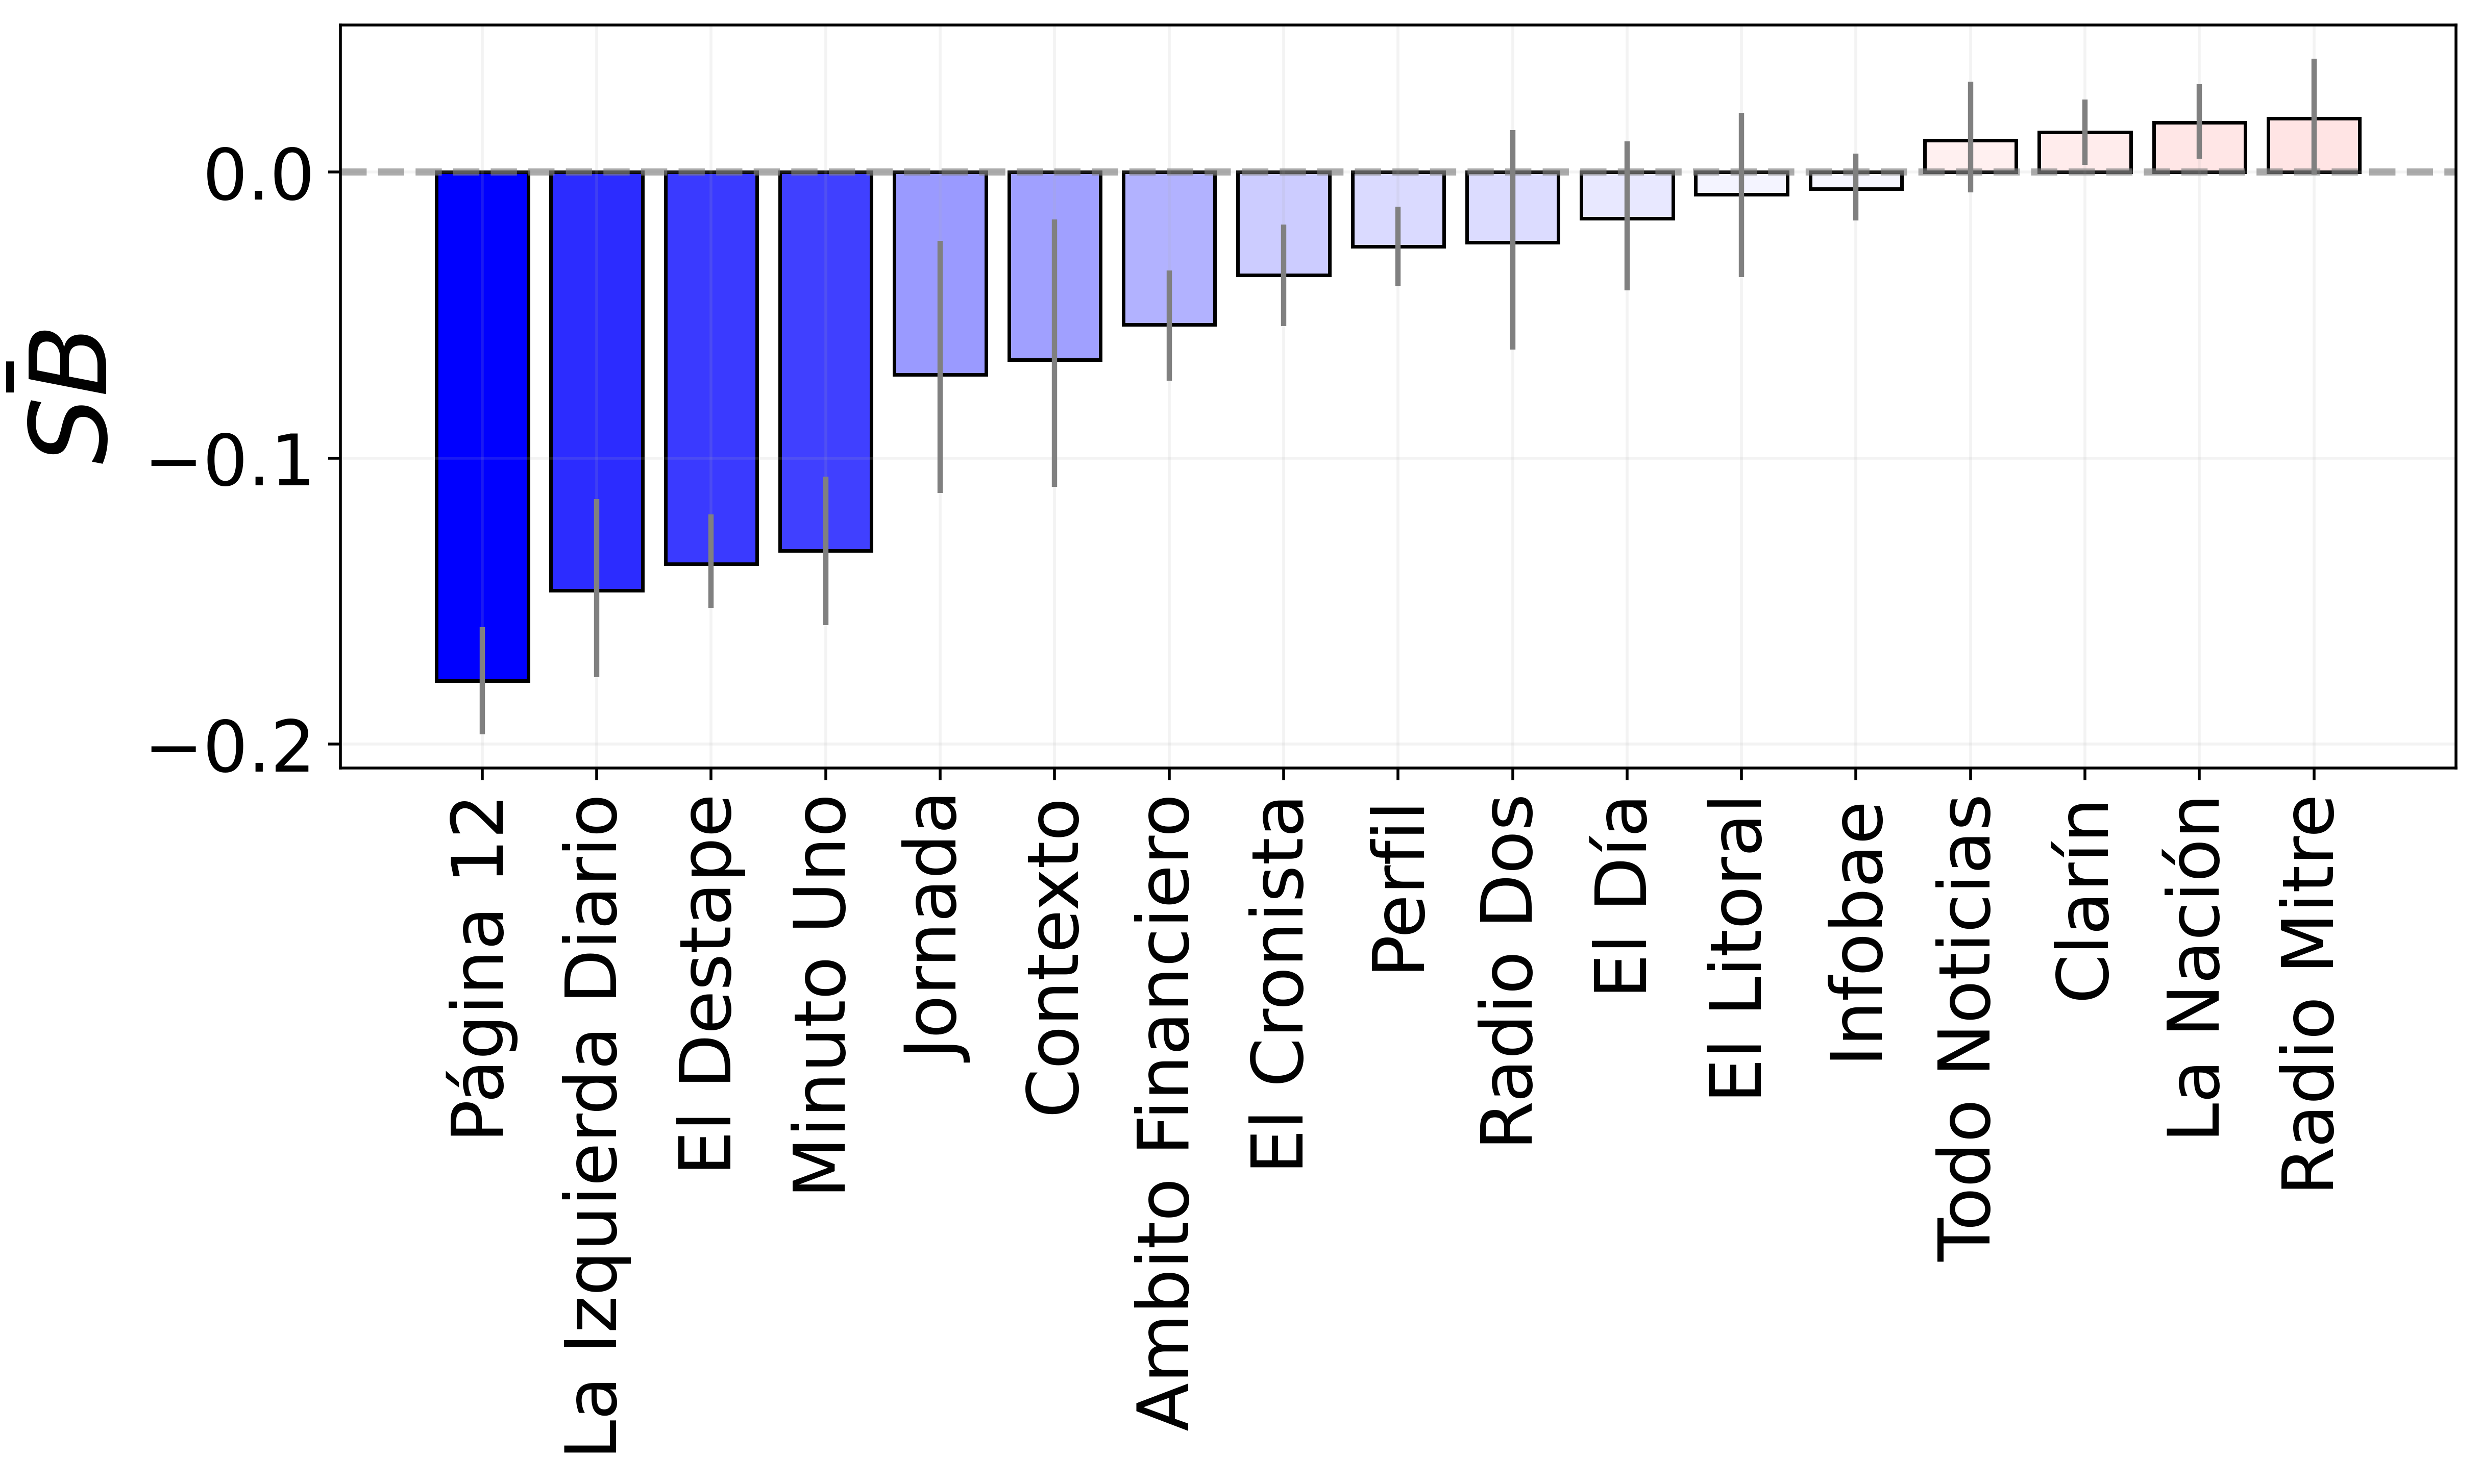

In [12]:
# Create the subplots
fig, ax1 = plt.subplots(figsize=(10,6),dpi = 500)

# Scale of colors where SB = 0 is white and the most extreme case has the most extreme color
colors = plt.cm.bwr((-0.5 * sb_by_outlet['SB'] / sb_by_outlet['SB'].min() + 0.5))

for i in range(sb_by_outlet.shape[0]):
    ax1.vlines(x = i, ymin=sb_by_outlet['1%'].to_list()[i], ymax=sb_by_outlet['99%'].to_list()[i], color = 'grey')

ax1.bar(range(sb_by_outlet.shape[0]), sb_by_outlet['SB'].to_list(), label = r'$\bar{SB}$ by outlet', color = colors, linewidth=1,edgecolor='black')   
ax1.set_xticks(range(sb_by_outlet.shape[0]))


sorted_outlets_accents = [add_accents(m) for m in sb_by_outlet.index]

ax1.set_xticklabels(sorted_outlets_accents, rotation=90)
ax1.axhline(0, linestyle = '--', color = 'grey', linewidth = 2, alpha = 0.65, label = r'$\bar{SB}=0$')
ax1.tick_params(axis='both', labelsize=20)
ax1.set_ylabel(r'$\bar{SB}$', size = 30)
ax1.grid(True, alpha = 0.15)

plt.tight_layout()
plt.savefig('New_figure2.pdf')
plt.show()